This notebook provides examples of how to call the hyperconvo functions from Convokit and perform analyses similar to the ones presented in the corresponding paper (http://www.cs.cornell.edu/~cristian/Patterns_of_participant_interactions.html), which describes the hypergraph methodology for modeling and analyzing online public discussions.

Note that due to limitations in what data we can access and distribute, the beta version of the hypergraph methodology presented here currently supports less functionality:

* Instead of Facebook data, we release a dataset of discussions from Reddit (the 1000 most recent threads, with at least 10 comments, from 100 highly active subreddits -- more details in the corresponding readme here: https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/tree/master/datasets/reddit-corpus). For demonstration purposes, we here use a small subset of this dataset ("reddit-corpus-small") containing 100 threads per subreddit.
* Since Reddit does not provide information on who reacted to (i.e., upvoted) each comment, we are presently unable to support reaction-edges in the hypergraph. As such, we can only compute features over in/outdegree distributions of _reply_-edges, and the feature set derived from motifs in the hypergraph is limited to counts and binary indicators or whether or not a motif is present. We will work  towards supporting reactions as well.

In [44]:
# import os
# os.getcwd()
# os.chdir("..")
# os.chdir("..")
# os.getcwd()

In [2]:
import convokit

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

First we download the reddit corpus:

In [4]:
corpus = convokit.Corpus(filename=convokit.download("reddit-corpus-small"))

Dataset already exists at /Users/macuser/.convokit/downloads/reddit-corpus-small


In [5]:
corpus.meta

{'subreddit': 'reddit-corpus-small',
 'num_posts': 8286,
 'num_comments': 288846,
 'num_user': 119889}

In [6]:
len(list(corpus.iter_utterances()))

297132

In [7]:
len(list(corpus.iter_users()))

119889

In [8]:
len(list(corpus.iter_conversations()))

8286

We will compute features over only the first 10 comments that occur in a thread, for  threads which are at least 10 comments long (controling for thread length in this way). Notice that we set include_root to False as we are interested in comment threads, i.e. threads that begin from a top-level comment, not from the post itself.

In [9]:
threads = corpus.utterance_threads(prefix_len=10, include_root=False)

The following are threads that come from the /r/canada subreddit. 

In [10]:
threads['e56rtrx']['e56rtrx']

Utterance({'id': 'e56rtrx', 'user': User([('name', 'Calculated_Lamp')]), 'root': '9byrus', 'reply_to': '9byrus', 'timestamp': 1535761916, 'text': "I'm not sure what that code is, but I can get you everything other than the weavile!", 'meta': {'score': 1, 'top_level_comment': 'e56rtrx', 'retrieved_on': 1538538870, 'gilded': 0, 'gildings': {'gid_1': 0, 'gid_2': 0, 'gid_3': 0}, 'subreddit': 'pokemontrades', 'stickied': False, 'permalink': '/r/pokemontrades/comments/9byrus/lf_some_pokémon_to_complete_ultra_moon_dex/e56rtrx/', 'author_flair_text': '4484-8592-5846 || Brandon (US)'}})

In [11]:
demo_threads = [
    # https://www.reddit.com/r/tifu/comments/9bzh9g/tifu_by_masturbating_with_my_dads_penis/e5717fs/
                'e5717fs', 
    # https://www.reddit.com/r/conspiracy/comments/9c45y5/papadopoulos_trump_approved_proposed_meeting_with/e57u6ft/
                'e57u6ft',
    # https://www.reddit.com/r/pokemontrades/comments/9byrus/lf_some_pokémon_to_complete_ultra_moon_dex/e56rtrx/
                'e56rtrx'
               ]

We print the structure of the thread: the reply-structure (where subsequent replies in the comment tree are indented), and the authors of each comment. There are some high-level qualitative differences that you might immediately see; our goal is to automatically extract a superset of these intuitive distinctions. For instance, some threads have a very linear structure, while others are flatter; to capture this difference, we might compute statistics on the distribution of in-degrees of nodes in the reply tree. We also intuit that some conversations involve a few people replying repeatedly to each other, whereas others may involve users stopping by to chime in once and then leaving; we'll later codify this difference via statistics on the indegrees and outdegrees of hypernodes (users).

In [12]:
for thread in demo_threads:
    print(thread)
    print('---')
    convokit.util.display_thread(threads, thread)
    print()

e5717fs
---
stephschiff
    Thizzmonk
        stephschiff
        ChiefThunderSqueak
            moreawkwardthenyou
                AssHiccups
                    Huntingprobs
                    Huntingprobs
                MajorNarsilion
            taichi22

e57u6ft
---
45ReasonsWhy
    WhatTheFisthatshit
        [deleted]
            WhatTheFisthatshit
                45ReasonsWhy
    eleven4for20
        45ReasonsWhy
            ganooosh
            eleven4for20
    CaptainObivous

e56rtrx
---
Calculated_Lamp
    VincentRivera
        Calculated_Lamp
            VincentRivera
            VincentRivera
                Calculated_Lamp
                    VincentRivera
                        Calculated_Lamp
                            VincentRivera
                                Calculated_Lamp



One technical note: Since we don't have access to the author of deleted comments, we make the assumption for now that each deleted comment in a particular thread was written by the same author -- a potential source of noise in the subsequent analyses.

The above method is called by fit_transform(), but we call the utterance_threads() method directly so we can visualize the thread. Typically, to extract hypergraph features, we would simply:

In [14]:
# create a hyperconvo object and use it to extract features
hc = convokit.HyperConvo(prefix_len=10, min_thread_len=10, include_root=False)
hc.fit_transform(corpus)

In [48]:
convos = corpus.iter_conversations()
convo1 = next(iter(convos))
convo1.meta.keys()
convo1.meta['hyperconvo']

{'e594ur8': {'max[outdegree over c->c responses]': 1,
  'max[indegree over c->c responses]': 5,
  'argmax[outdegree over c->c responses]': 1,
  'argmax[indegree over c->c responses]': 0,
  'norm.max[outdegree over c->c responses]': 0.1111111111111111,
  'norm.max[indegree over c->c responses]': 0.5555555555555556,
  '2nd-largest[outdegree over c->c responses]': 1,
  '2nd-largest[indegree over c->c responses]': 2,
  '2nd-argmax[outdegree over c->c responses]': 2,
  '2nd-argmax[indegree over c->c responses]': 4,
  'norm.2nd-largest[outdegree over c->c responses]': 0.1111111111111111,
  'norm.2nd-largest[indegree over c->c responses]': 0.2222222222222222,
  'mean[outdegree over c->c responses]': 0.9,
  'mean[indegree over c->c responses]': 0.9,
  'mean-nonzero[outdegree over c->c responses]': 1.0,
  'mean-nonzero[indegree over c->c responses]': 2.25,
  'prop-nonzero[outdegree over c->c responses]': 0.9,
  'prop-nonzero[indegree over c->c responses]': 0.4,
  'prop-multiple[outdegree over c

Hyperconvo's fit_transform() method generates features data for each thread (either starting with the post or top-level comment) and stores it in the corresponding Conversation's (which is indexed by post id) metadata. We collect the thread features from each Conversation to do some aggregated analysis.

In [15]:
threads_feats = dict()
convos = corpus.iter_conversations()

for convo in convos:
    threads_feats.update(convo.meta['hyperconvo'])


In [17]:
def clean_value(x):
    if np.isinf(x) or np.isnan(x):
        return -1
    return x

In [18]:
feat_names = list(next(iter(threads_feats.values())).keys())

In [19]:
feat_names[:10]

['max[outdegree over c->c responses]',
 'max[indegree over c->c responses]',
 'argmax[outdegree over c->c responses]',
 'argmax[indegree over c->c responses]',
 'norm.max[outdegree over c->c responses]',
 'norm.max[indegree over c->c responses]',
 '2nd-largest[outdegree over c->c responses]',
 '2nd-largest[indegree over c->c responses]',
 '2nd-argmax[outdegree over c->c responses]',
 '2nd-argmax[indegree over c->c responses]']

In [20]:
thread_ids = []
feats = []
for key, feat_dict in threads_feats.items():
    thread_ids.append(key)
    feats.append([clean_value(feat_dict[k]) for k in feat_names])

For later convenience we will store feature values in a dataframe:

In [21]:
feat_df = pd.DataFrame(data=feats, index=thread_ids, columns=feat_names)

Here are some examples of features computed over the three example threads from before:

In [22]:
C_C_indegree_feats = [x for x in feat_names if 'indegree over C->C responses' in x]
C_C_mid_outdegree_feats = [x for x in feat_names if 'outdegree over C->C mid-thread responses' in x]
motif_count_feats = [x for x in feat_names if ('count' in x) and ('mid' not in x)]

Features derived from the distribution of hypernode to hypernode indegrees (i.e., "how many other people are responding to a particular discussion participant?"). As in the paper, we compute various summary statistics over the distribution. 

As noted at the start of this notebook, since we do not have access to reaction information, these distributions encompass only the reply structure within the thread.

In [23]:
feat_df.loc[demo_threads][C_C_indegree_feats].T.sort_index()

,e5717fs,e57u6ft,e56rtrx
2nd-argmax[indegree over C->C responses],2.000000,1.000000,1.000000
2nd-largest / max[indegree over C->C responses],1.000000,0.400000,0.800000
2nd-largest[indegree over C->C responses],2.000000,2.000000,4.000000
argmax[indegree over C->C responses],1.000000,0.000000,0.000000
entropy[indegree over C->C responses],1.581094,1.149060,0.686962
max[indegree over C->C responses],2.000000,5.000000,5.000000
mean-nonzero[indegree over C->C responses],1.800000,2.250000,4.500000
mean[indegree over C->C responses],1.125000,1.500000,4.500000
norm.2nd-largest[indegree over C->C responses],0.222222,0.222222,0.444444
norm.max[indegree over C->C responses],0.222222,0.555556,0.555556


Features derived from the distribution of hypernode to hypernode outdegrees in the _middle_ of the thread (i.e., "beyond the root comment, how many other people is each participant responding to?"). 

In [24]:
feat_df.loc[demo_threads][C_C_mid_outdegree_feats].T.sort_index()

,e5717fs,e57u6ft,e56rtrx
2nd-argmax[outdegree over C->C mid-thread responses],1.000000,0.000000,1.000000
2nd-largest / max[outdegree over C->C mid-thread responses],0.500000,0.500000,1.000000
2nd-largest[outdegree over C->C mid-thread responses],1.000000,1.000000,4.000000
argmax[outdegree over C->C mid-thread responses],7.000000,3.000000,0.000000
entropy[outdegree over C->C mid-thread responses],1.906155,1.560710,0.693147
max[outdegree over C->C mid-thread responses],2.000000,2.000000,4.000000
mean-nonzero[outdegree over C->C mid-thread responses],1.142857,1.200000,4.000000
mean[outdegree over C->C mid-thread responses],1.000000,1.000000,4.000000
norm.2nd-largest[outdegree over C->C mid-thread responses],0.125000,0.166667,0.500000
norm.max[outdegree over C->C mid-thread responses],0.250000,0.333333,0.500000


Features derived from the 5 motifs considered in the paper. Note that because we do not have reply information, we instead take as features _counts_ of each motif (in the paper, we would additionally compare reply or reaction edge types within motifs of a particular form)

In [25]:
feat_df.loc[demo_threads][motif_count_feats].T.sort_index()

,e5717fs,e57u6ft,e56rtrx
count[dyadic interaction motif],2,8,40
count[external reciprocity motif],7,3,0
count[incoming triads],3,10,0
count[outgoing triads],11,20,56
count[reciprocity motif],1,3,8


While the features generated above can be used as is (e.g., as features in a prediction task), we can also interpret them by projecting them into a low-dimensional space. 

In [26]:
from sklearn.preprocessing import Imputer, Normalizer, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import pairwise_distances

In [27]:
feat_mtx = Imputer(axis=1, missing_values=-1).fit_transform(feat_df.values)
feat_mtx = StandardScaler().fit_transform(feat_mtx)

In [28]:
svd = TruncatedSVD(n_components=7, algorithm='arpack') # deals with an issue where the randomized alg hangs
svd.fit(feat_mtx)
U, s, V = svd.transform(feat_mtx) / svd.singular_values_, \
        svd.singular_values_, \
        svd.components_.T

In [29]:
U_norm = Normalizer().fit_transform(U)
V_norm = Normalizer().fit_transform(V)
U_df = pd.DataFrame(data=U_norm, index=feat_df.index)
V_df = pd.DataFrame(data=V_norm, index=feat_names)

This embedding procedure produces embeddings of threads in the low-dimensional space:

In [30]:
U_df.loc[demo_threads].T

,e5717fs,e57u6ft,e56rtrx
0,-0.198059,-0.088648,0.806113
1,-0.471295,-0.273673,0.276566
2,0.260131,-0.330876,0.064748
3,0.428210,0.012822,-0.318520
4,0.436187,-0.228265,-0.104498
5,0.391530,0.818008,0.370947
6,-0.379561,-0.293871,0.139730


As well as embeddings of features:

In [31]:
V_df.loc[C_C_indegree_feats]

,0,1,2,3,4,5,6
max[indegree over C->C responses],-0.009770,0.812951,0.068530,-0.496592,-0.287380,-1.367235e-16,0.071611
argmax[indegree over C->C responses],0.043852,-0.429629,0.492663,-0.422184,0.160153,-2.769485e-16,0.605715
norm.max[indegree over C->C responses],-0.009861,0.813162,0.068677,-0.496828,-0.286313,1.093766e-15,0.071705
2nd-largest[indegree over C->C responses],0.469688,-0.155532,0.581288,0.063694,-0.280932,1.409957e-15,-0.578211
2nd-argmax[indegree over C->C responses],-0.094280,0.205070,-0.210629,0.683533,-0.435193,3.786862e-15,-0.498079
norm.2nd-largest[indegree over C->C responses],0.261550,0.312377,0.497863,0.618703,-0.377827,1.111886e-15,0.246165
mean[indegree over C->C responses],0.758078,0.519200,0.307214,0.162900,-0.185217,1.719781e-15,0.022952
mean-nonzero[indegree over C->C responses],0.244614,0.782658,0.505372,-0.226986,0.076522,6.870566e-16,-0.121787
prop-nonzero[indegree over C->C responses],0.819261,-0.257694,-0.447331,0.086338,0.180655,1.693273e-15,0.149031
prop-multiple[indegree over C->C responses],0.296549,0.195015,0.572523,-0.148814,0.237326,8.196840e-16,-0.683942


As in the paper, for further interpretability we can consider embeddings of _communities_ (subreddits, standing for Facebook pages) in terms of the discussions they foster, by averaging the embeddings of all threads in a particular subreddit.

In [32]:
def get_subreddit(threads, thread_id):
    return threads[thread_id][thread_id].meta["subreddit"]



In [33]:
subreddits = [get_subreddit(threads, thread_id) for thread_id in threads]
U_df['subreddit'] = subreddits

In [34]:
subreddit_means = U_df.groupby('subreddit').mean()
subreddit_df = pd.DataFrame(
        data=Normalizer().fit_transform(subreddit_means.values),
        index = subreddit_means.index
    )

First, let's give a rough overview of the space we've sketched out through this procedure, by visualizing the subreddit embeddings using the TSNE algorithm.

In [35]:
tsne = TSNE(random_state=2018)
tsne_df = pd.DataFrame(data=tsne.fit_transform(subreddit_df.values),
                      index=subreddit_df.index)

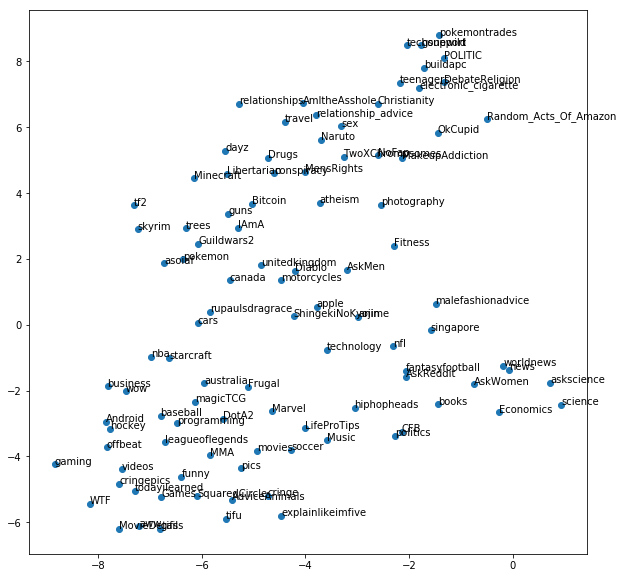

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_df[0].values, tsne_df[1].values)
for i, txt in enumerate(tsne_df.index):
    plt.annotate(txt, (tsne_df.values[i,0], tsne_df.values[i,1]))
plt.show()

Looking across this plot, we can spot a few interpretable-looking groupings:

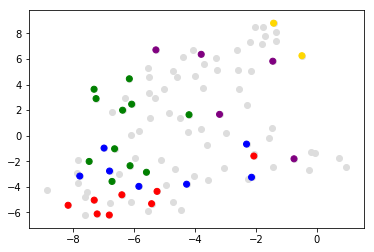

In [37]:
games = ["battlefield3", "Diablo", "DotA2", "Guildwars2", "leagueoflegends", "magicTCG", "Minecraft", "pokemon", "skyrim", "starcraft", "tf2", "wow"]
trade = ["Dota2Trade", "pokemontrades", "SteamGameSwap", "tf2trade", "Random_Acts_Of_Amazon"]
sports = ["baseball", "CFB", "hockey", "MMA", "nba", "nfl", "soccer"]

link_aggregators = ["AskReddit", "WTF", "pics", "gifs", "aww", "funny", "todayilearned",
                   "AdviceAnimals"]
relationships = ["AskMen", "AskWomen", "relationships", "relationship_advice", "OkCupid"]

plt.scatter(tsne_df[0].values, tsne_df[1].values, color="#dddddd")
plt.scatter(tsne_df[0].values, tsne_df[1].values, color=[
    "green" if l in games else
    "gold" if l in trade else
    "purple" if l in relationships else
    "red" if l in link_aggregators else
    "blue" if l in sports else
    "#00000000"
    for l in tsne_df.index])
plt.show()

For instance, video games (e.g., tf2, DotA2; red) tend to group together, along with buy-sell subreddits (e.g., tf2trade, Dota2Trade, yellow), subreddits related to relationships (e.g., AskWomen, relationship_advice; green) and large default-subreddit hubs for sharing random links (e.g., pics, AskReddit; purple).

There may be other interesting groupings that you may spot as well -- for instance, a vaguely right-wing MensRights cluster (with Libertarian, guns); a rather intriguing cluster consisting of politics, sex, business, etc.

Some topical groups are more diffuse -- for instance, sports-based subreddits (blue). Perhaps this is a limitation of our representation, or that these subreddits actually foster very different interactional dynamics.

Another way to delve into these groupings is to look at nearest neighbors of subreddits, in terms of the embedding:

In [38]:
dists = pairwise_distances(subreddit_df.values, metric='cosine')
flat_dists = np.ravel(dists)
idx1, idx2 = np.unravel_index(np.arange(len(flat_dists)), dists.shape)
pairwise_dist_df = pd.DataFrame.from_dict({'p1': subreddit_df.index[idx1],
                                           'p2': subreddit_df.index[idx2],
                                           'dist': flat_dists},
                                           orient='columns')

In [39]:
def print_nearest_neighbors(pairwise_dist_df, 
                           test_subreddits=[],
                           top_N=10):
    for subreddit in test_subreddits:
        subset_df = pairwise_dist_df[(pairwise_dist_df.p1 == subreddit)
                                 & (pairwise_dist_df.p2 != subreddit)]
        print(subreddit)
        print(subset_df.sort_values('dist')[['p2', 'dist']].head(top_N))
        print()

In [40]:
print_nearest_neighbors(pairwise_dist_df, ['apple', 'politics', 'leagueoflegends',
                                          'AskWomen', 'Music', 'pics',
                                          'australia', 'Random_Acts_Of_Amazon',
                                          'Bitcoin', 'MensRights'])

apple
                    p2      dist
3833  ShingekiNoKyojin  0.004017
3810            Diablo  0.006825
3888        technology  0.009393
3867       motorcycles  0.010524
3837             anime  0.016090
3803            AskMen  0.016638
3896     unitedkingdom  0.017630
3881   rupaulsdragrace  0.018646
3848            canada  0.020107
3871               nfl  0.023298

politics
               p2      dist
7707          CFB  0.023587
7727        Music  0.024530
7786       soccer  0.030127
7704    AskReddit  0.032817
7768       movies  0.037121
7745        books  0.040128
7762  hiphopheads  0.040301
7788   technology  0.042719
7715       Frugal  0.046723
7703       AskMen  0.047625

leagueoflegends
                 p2      dist
6478    programming  0.008081
6444       baseball  0.010526
6465       magicTCG  0.012686
6499            wow  0.013438
6411          DotA2  0.014148
6457          funny  0.014572
6463         hockey  0.015803
6451         cringe  0.016402
6474           pics  0.018

We can also try to interpret each dimension of the embedding -- roughly speaking the threads, features and subreddits with extremal values along one dimension could be seen as characterizing a particular "type" of discussion, in terms of the discussion structure.

In [41]:
from IPython.display import display

In [42]:
def display_dimension(dim, ascending=True, n=5):
    top_threads = U_df.sort_values(dim, ascending=ascending).head(n)
    display(top_threads)
    display(V_df.sort_values(dim, ascending=ascending).head(n))
    display(subreddit_df.sort_values(dim, ascending=ascending).head(n))
    return top_threads.index

For instance, the first latent dimension divides the space of Reddit discussions between focused dialogues involving 2 people who repeatedly interact, and "expansionary" threads involving multiple people who generally only engage once (as with the corresponding dimension discussed in the paper, this echoes the contrast explored in papers such as Backstrom et. al, 2013). At the subreddit level, we see a divide between subreddits that are selling things (perhaps the dialogues consist of a buyer and a seller) and large default link-sharing subreddits like AskReddit and pics.

In [43]:
top_threads = display_dimension(0, n=10)

,0,1,2,3,4,5,6,subreddit
e6pf15q,-0.676623,0.513830,0.134802,0.020928,-0.177938,0.477028,0.018281,aww
e68jh0j,-0.673430,0.205880,-0.081717,0.263906,-0.246259,0.589432,0.140384,AdviceAnimals
e5sph0s,-0.670253,0.169118,-0.041635,0.072457,-0.158797,0.614932,0.334394,politics
e6oe9ov,-0.668205,0.221866,-0.058121,0.169387,-0.291089,0.610766,0.120169,DotA2
e62qyda,-0.665898,0.169078,-0.057850,0.150591,-0.193394,0.599331,0.324606,malefashionadvice
e5bfol4,-0.665640,0.207050,-0.087454,0.133069,-0.264442,0.595517,0.253233,hiphopheads
e5w7xfe,-0.665095,0.504702,0.183625,0.128926,-0.176277,0.453348,0.126435,gifs
e6wd02c,-0.665004,0.500952,0.167674,0.024282,-0.199629,0.456416,0.173045,programming
e5zrsyw,-0.664761,0.235913,-0.046376,0.192647,-0.179544,0.601323,0.263342,pics
e60eyqo,-0.662864,0.489703,0.145063,0.065251,-0.306050,0.449119,-0.011273,cringe


,0,1,2,3,4,5,6
entropy[outdegree over C->C responses],-0.837425,-0.310025,-0.068734,0.294584,-0.061573,-8.786380e-16,0.327581
entropy[outdegree over C->c responses],-0.837352,-0.310132,-0.068769,0.294664,-0.061841,8.786028e-17,0.327537
is-present[incoming triads],-0.680980,-0.547112,-0.298469,-0.299941,0.163346,7.699022e-16,-0.176648
norm.max[indegree over C->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,5.261588e-16,0.289414
max[indegree over c->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,2.254966e-16,0.289414
max[indegree over C->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,2.254966e-16,0.289414
norm.max[indegree over c->c responses],-0.566327,0.670571,-0.016447,-0.303844,-0.230775,7.516555e-17,0.289414
count[incoming triads],-0.518919,0.545870,-0.013800,-0.641926,-0.097235,7.782133e-16,-0.105046
is-present[external reciprocity motif],-0.497952,-0.805894,0.151832,0.107318,-0.228744,1.939942e-15,0.125237
argmax[outdegree over C->c responses],-0.435357,-0.340004,-0.212094,0.793083,0.000368,-8.859015e-15,-0.144557


,0,1,2,3,4,5,6
subreddit,,,,,,,
aww,-0.436198,-0.186731,0.151108,0.221554,-0.041266,0.835250,0.059975
gifs,-0.435152,-0.145047,0.105541,0.148374,-0.063803,0.854395,0.149630
WTF,-0.410492,-0.201358,0.006283,0.308857,-0.016694,0.826694,0.108703
MovieDetails,-0.410025,-0.238155,0.083465,0.166898,-0.117559,0.836015,0.166133
CFB,-0.406583,0.136184,-0.122507,0.023378,-0.084056,0.890159,0.033780
Games,-0.393687,-0.089679,0.034024,0.201206,-0.059803,0.888856,0.041060
todayilearned,-0.371113,-0.188680,0.021057,0.204484,-0.023254,0.880784,0.089979
books,-0.356163,0.163736,-0.117505,0.010360,-0.127874,0.881824,-0.196109
videos,-0.350594,-0.197875,-0.043432,0.205159,-0.007386,0.887549,0.078452
